<p style="font-size:200%;text-align:center;font-family:verdana">PREDICTING  AIR QUALITY USING TIME SERIES ANALYSIS<p>

<h1>1.Data Information</h1>

<h2>1.1 Data Source</h2>
<h2>Source:</h2><br>
1.https://data.gov.in/resources/location-wise-daily-ambient-air-quality-telangana-year-2014<br>
2.https://data.gov.in/resources/location-wise-daily-ambient-air-quality-telangana-year-2015
 

<h2>1.2Data Overview</h2>

<img src="dataoverview_snapshot.png" alt="Data Overview">

1. Stn_code: Represents code of a Place.<br>
2. Date: On which date the readings are taken.<br>
3. State: Telangana.<br>
4. City: Represent cities in Telangana state.<br>
5. Location: The place in city where the readings are taken.<br>
6. Agency: By which board the readings are taken(Andhra Pradesh State Pollution Control Board).<br>
7. Area : They are Industrial Areas, Sensitive Areas and Residential Areas<br>
8.  SO2: Sulphur Dioxide
9.  NO2: Nitrogen dioxide
10. PM10:Particulate matter

<h2>1.3 Performance metrics</h2>

Mean Absolute error : MAE is the average of the absolute difference between the predicted values and observed value.

## 2.Exploratory Data Analysis

In [2]:
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

<h2>2.1.Data Pre-processing</h2>

In [5]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('dataframe.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


ValueError: 'year' is not in list

In [6]:
print(dataset)

NameError: name 'dataset' is not defined

In [4]:
type(dataset)

pandas.core.frame.DataFrame

In [5]:
dataset.isnull().sum()

Unnamed: 0    0
Stn_code      0
Date          0
State         0
City          0
Location      0
Agency        0
Area          0
SO2           0
NO2           0
PM10          0
dtype: int64

* As we observe there are no null values in the dataset.

In [6]:
# Displaying the column names
dataset.columns

Index(['Unnamed: 0', 'Stn_code', 'Date', 'State', 'City', 'Location', 'Agency',
       'Area', 'SO2', 'NO2', 'PM10'],
      dtype='object')

In [7]:
#Changing the names of the columns
dataset.columns=['index','Stn_code','Date','State','City','Location','Agency','Area','SO2','NO2','PM10']

In [8]:
dataset=dataset.drop(columns=['index','State','City','Location','Agency','Area'])

* Droping the columns that are not required for analysis

### 2.1.1.Changing the values of SO2, NO2, PM10 to a single unit as Air Quality Index(AQI)

#### AQI=I.low+((I.high-I.low)*(C-C.low)/(C.high-C.low))<br>
where:<br>
I =  the (Air Quality) index,<br>
C =  the pollutant concentration,<br>
C.low=  the concentration breakpoint that is ≤ C,<br>
C.high=  the concentration breakpoint that is  ≥ C,<br>
I.low=  the index breakpoint corresponding to C.low,<br>
I.high=  the index breakpoint corresponding to C,high.<br>
#### reference:https://en.wikipedia.org/wiki/Air_quality_index

In [9]:
#Function to calculate so2 individual pollutant index(si)
def calculate_si(so2):
    si=0
    if (so2<=40):
         si= so2*(50/40)
    if (so2>40 and so2<=80):
         si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
         si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
         si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
         si= 300+(so2-800)*(100/800)
    if (so2>1600):
         si= 400+(so2-1600)*(100/800)
    return si
dataset['si']=dataset['SO2'].apply(calculate_si)
df= dataset[['SO2','si']]
df.head()

,SO2,si
0,5.0,6.25
1,5.0,6.25
2,5.0,6.25
3,6.0,7.50
4,5.0,6.25


In [10]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
        ni= no2*50/40
    elif(no2>40 and no2<=80):
         ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
         ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
         ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
         ni= 300+(no2-280)*(100/120)
    else:
         ni= 400+(no2-400)*(100/120)
    return ni
dataset['ni']=dataset['NO2'].apply(calculate_ni)
df= dataset[['NO2','ni']]
df.head()

,NO2,ni
0,26.0,32.50
1,27.0,33.75
2,30.0,37.50
3,24.0,30.00
4,29.0,36.25


In [11]:
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
         rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
         rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
         rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
         rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
         rpi=300+(rpi-120)*(100/130)
    else:
         rpi=400+(rpi-250)*(100/130)
    return rpi
dataset['rpi']=dataset['PM10'].apply(calculate_si)
df= dataset[['PM10','rpi']]
df.head()

,PM10,rpi
0,217,145.666667
1,136,118.666667
2,130,116.666667
3,78,97.500000
4,110,110.000000


### 2.1.2.Merging the calculated pollutant index of SO2, NO2, PM10

In [12]:
def calculate_aqi(si,ni,spi):
    aqi=0
    if(si>ni and si>spi):
        aqi=si
    if(spi>si and spi>ni):
        aqi=spi
    if(ni>si and ni>spi):
        aqi=ni
    return aqi
dataset['AQI']=dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['rpi']),axis=1)
df= dataset[['Stn_code','Date','SO2','NO2','PM10','AQI']]
df.head()

,Stn_code,Date,SO2,NO2,PM10,AQI
0,95,1/3/2014,5.0,26.0,217,145.666667
1,95,1/6/2014,5.0,27.0,136,118.666667
2,95,1/9/2014,5.0,30.0,130,116.666667
3,95,1/12/2014,6.0,24.0,78,97.500000
4,95,1/16/2014,5.0,29.0,110,110.000000


## 2.3Univariate analysis
### 2.3.1 Data Cleaning

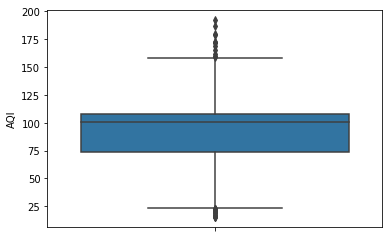

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(y='AQI', data=dataset)
plt.show()

In [14]:
import numpy as np
for i in range(0,100,10):
    var =dataset["AQI"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 15.0
10 percentile value is 55.0
20 percentile value is 68.75
30 percentile value is 78.75
40 percentile value is 90.0
50 percentile value is 100.33333333333333
60 percentile value is 103.0
70 percentile value is 105.66666666666667
80 percentile value is 110.33333333333333
90 percentile value is 119.0
100 percentile value is  192.33333333333331


In [16]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =dataset["AQI"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(0+i,var[int(len(var)*(float(0+i)/100))]))
print("100 percentile value is ",var[-1])

0.0 percentile value is 15.0
0.1 percentile value is 16.25
0.2 percentile value is 20.0
0.30000000000000004 percentile value is 21.25
0.4 percentile value is 22.5
0.5 percentile value is 25.0
0.6000000000000001 percentile value is 25.0
0.7000000000000001 percentile value is 26.25
0.8 percentile value is 26.25
0.9 percentile value is 27.5
100 percentile value is  192.33333333333331


In [17]:
import numpy as np
for i in range(90,100):
    var =dataset["AQI"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 119.0
91 percentile value is 120.33333333333333
92 percentile value is 122.0
93 percentile value is 123.33333333333333
94 percentile value is 124.66666666666666
95 percentile value is 126.33333333333333
96 percentile value is 128.5
97 percentile value is 131.33333333333334
98 percentile value is 135.33333333333331
99 percentile value is 142.33333333333331
100 percentile value is  192.33333333333331


In [18]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =dataset["AQI"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 142.33333333333331
99.1 percentile value is 144.0
99.2 percentile value is 145.33333333333331
99.3 percentile value is 146.66666666666666
99.4 percentile value is 148.33333333333331
99.5 percentile value is 149.33333333333331
99.6 percentile value is 154.0
99.7 percentile value is 158.66666666666666
99.8 percentile value is 168.66666666666666
99.9 percentile value is 178.66666666666666
100 percentile value is  192.33333333333331


* There are no much outliers in the data set.

In [19]:
dataset_modified=dataset[(dataset.AQI>100) & (dataset.AQI<193)]

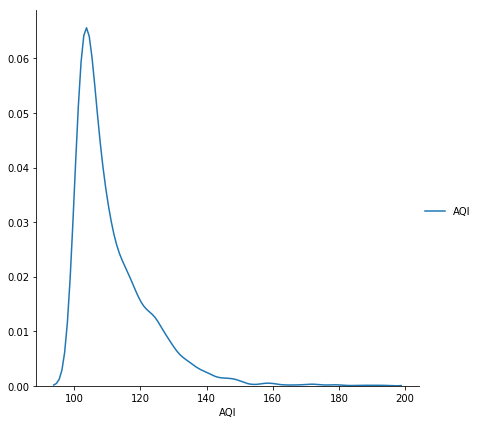

In [21]:
sns.FacetGrid(dataset_modified,height=6) \
      .map(sns.kdeplot,"AQI") \
      .add_legend();
plt.show();

In [22]:
print((dataset_modified.shape[0]/dataset.shape[0])*100)

50.37707390648567


* After removing the outliers we have 50.3% of data preserved

## 3.Observing the trend

* After seperating Date and Air quality from the dataset.

In [23]:
import pandas as pd
df=dataset_modified[['AQI','Date']]
df["Date"] = pd.to_datetime(df['Date'])
df.head()

,AQI,Date
0,145.666667,2014-01-03
1,118.666667,2014-01-06
2,116.666667,2014-01-09
4,110.000000,2014-01-16
6,124.666667,2014-01-21


In [24]:
df.shape

(2004, 2)

* As we observe there is no regular interval between the data.Let's make a easy way for analysis of data.
* So, We take the average of monthly wise data to have regular intervals(month-wise).

In [25]:
df=df.set_index('Date').resample('M')["AQI"].mean()
df.head()

Date
2014-01-31    112.618168
2014-02-28    116.115550
2014-03-31    110.199914
2014-04-30    112.884587
2014-05-31    112.169417
Freq: M, Name: AQI, dtype: float64

In [26]:
df.shape

(24,)

* As the dataset consists of two years(24 months) of data so we got 24 observations after performing average operations.

In [27]:
# Arranging the Date format
data=df.reset_index(level=0, inplace=False)
data = data[np.isfinite(data['AQI'])]
data=data[data.Date != '1970-01-31']
data = data.reset_index(drop=True)
data.head()

,Date,AQI
0,2014-01-31,112.618168
1,2014-02-28,116.115550
2,2014-03-31,110.199914
3,2014-04-30,112.884587
4,2014-05-31,112.169417


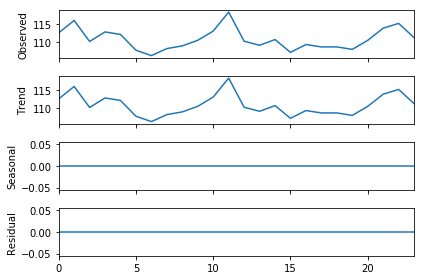

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = data.AQI
result = seasonal_decompose(series, model='additive', freq=1)
result.plot()
pyplot.show()

## 3.1.Observations:
* From the Trend curve we can see that the curve is in the form of sin(x) Curve there are up's and down's at regular intervals.
* And we can also observe that there is no Seasonality in the data.

## 4. Train Test Split
* As it is Time series data we cannot split the data randomly we need to split according to time.
* Train data contain 70% of Data and Test contain 30% of data.

In [29]:
n = df.shape[0]
train_size = 0.70

features_dataframe = data.sort_values('Date')
train = data.iloc[:int(n * train_size)]
test = data.iloc[int(n * train_size):]

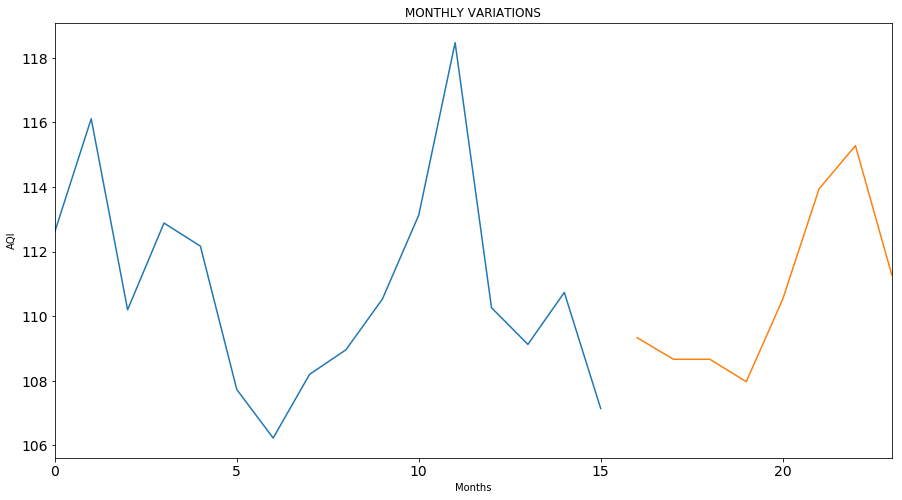

In [30]:
train.AQI.plot(figsize=(15,8), title= 'MONTHLY VARIATIONS', fontsize=14)
test.AQI.plot(figsize=(15,8), title= 'MONTHLY VARIATIONS', fontsize=14)
plt.xlabel("Months")
plt.ylabel("AQI")
plt.show()

# Machine learning models
### 1.Naive Approch(Base Line model)

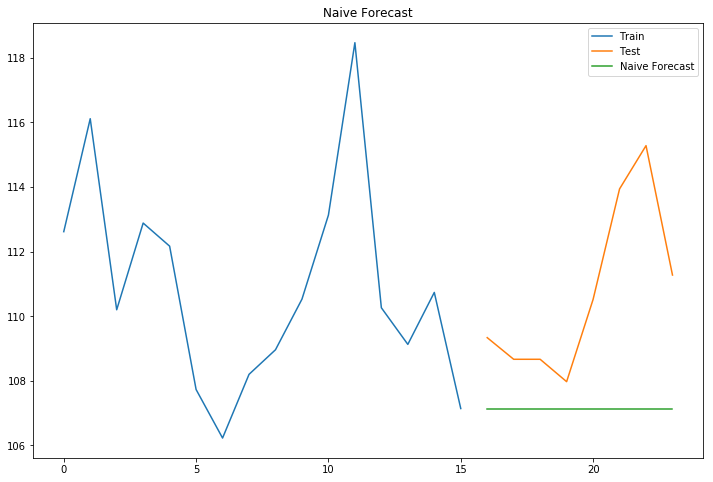

In [31]:
dd= np.asarray(train.AQI)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['AQI'], label='Train')
plt.plot(test.index,test['AQI'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test.AQI,  y_hat.naive)
print("Mean_absolute_error:",mae)

Mean_absolute_error: 3.5660317028976483


In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Date","Actual", "Predicted"]

x.add_row([data['Date'].loc[18],data['AQI'].loc[18],y_hat.naive[16]])
x.add_row([data['Date'].loc[19],data['AQI'].loc[19],y_hat.naive[17]])
x.add_row([data['Date'].loc[20],data['AQI'].loc[20],y_hat.naive[18]])
x.add_row([data['Date'].loc[21],data['AQI'].loc[21],y_hat.naive[19]])
x.add_row([data['Date'].loc[22],data['AQI'].loc[22],y_hat.naive[20]])
x.add_row([data['Date'].loc[23],data['AQI'].loc[23],y_hat.naive[21]])

print(x)

+---------------------+--------------------+--------------------+
|         Date        |       Actual       |     Predicted      |
+---------------------+--------------------+--------------------+
| 2015-07-31 00:00:00 | 108.66666666666666 | 107.14166666666668 |
| 2015-08-31 00:00:00 | 107.97348484848486 | 107.14166666666668 |
| 2015-09-30 00:00:00 | 110.51999999999998 | 107.14166666666668 |
| 2015-10-31 00:00:00 | 113.94157088122603 | 107.14166666666668 |
| 2015-11-30 00:00:00 | 115.28183520599252 | 107.14166666666668 |
| 2015-12-31 00:00:00 | 111.27491408934704 | 107.14166666666668 |
+---------------------+--------------------+--------------------+


### 2. Simple Moving Average

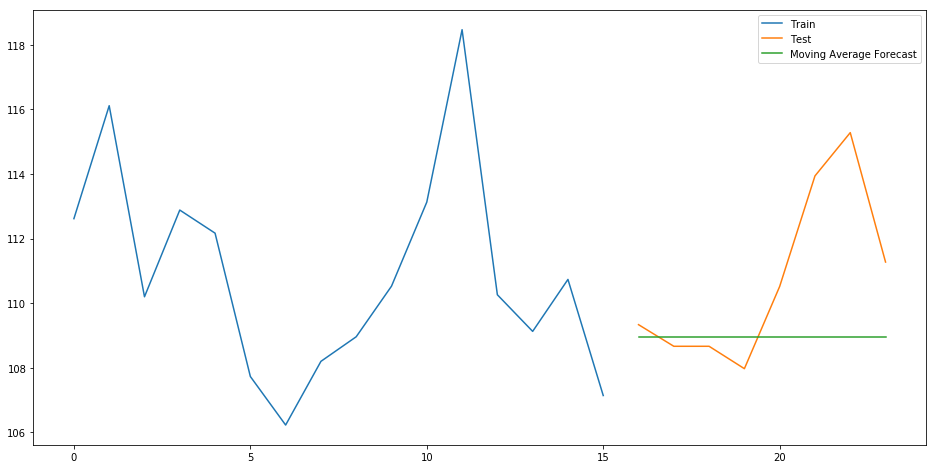

In [35]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['AQI'].rolling(2).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['AQI'], label='Train')
plt.plot(test['AQI'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [37]:
mae=mean_absolute_error(test.AQI, y_hat_avg.moving_avg_forecast)
print("Mean_absolute_percentage_error:",mae)

Mean_absolute_percentage_error: 2.1461802276185526


## 3.LSTM
### 3.1 Day wise

<img src="LSTM.png" alt="Data Overview">

reference:<br>
1.https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ <br>
2.https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [113]:
df=dataset_modified[['AQI']]

In [114]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [115]:
numpy.random.seed(7)

In [116]:
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')

In [117]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [118]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1603 401


In [119]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [120]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [121]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f

In [122]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 4s - loss: 0.0143
Epoch 2/20
 - 3s - loss: 0.0131
Epoch 3/20
 - 3s - loss: 0.0130
Epoch 4/20
 - 2s - loss: 0.0130
Epoch 5/20
 - 3s - loss: 0.0130
Epoch 6/20
 - 2s - loss: 0.0129
Epoch 7/20
 - 3s - loss: 0.0129
Epoch 8/20
 - 3s - loss: 0.0129
Epoch 9/20
 - 3s - loss: 0.0129
Epoch 10/20
 - 3s - loss: 0.0129
Epoch 11/20
 - 2s - loss: 0.0129
Epoch 12/20
 - 3s - loss: 0.0128
Epoch 13/20
 - 3s - loss: 0.0129
Epoch 14/20
 - 3s - loss: 0.0129
Epoch 15/20
 - 3s - loss: 0.0128
Epoch 16/20
 - 3s - loss: 0.0128
Epoch 17/20
 - 2s - loss: 0.0128
Epoch 18/20
 - 2s - loss: 0.0128
Epoch 19/20
 - 2s - loss: 0.0128
Epoch 20/20
 - 3s - loss: 0.0128


In [83]:
filepath = "daily lstm.h5"
model.save(filepath)

In [84]:
from keras.models import load_model
model = load_model('daily lstm.h5')


In [123]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate mean Absolute error
trainScore1 = math.sqrt(mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE'%(trainScore1))
testScore = math.sqrt(mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))

Train Score: 2.74 MAE
Test Score: 2.52 MAE


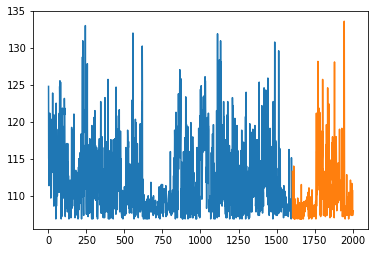

In [124]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [125]:
predictions = model.predict(testX)
print(predictions)

[[0.14140733]
 [0.11230099]
 [0.07341133]
 [0.11395191]
 [0.08028772]
 [0.07341133]
 [0.13185485]
 [0.08712089]
 [0.09896435]
 [0.14924455]
 [0.11230099]
 [0.08541688]
 [0.07168593]
 [0.08028772]
 [0.08712089]
 [0.07168593]
 [0.07341133]
 [0.10064348]
 [0.09052017]
 [0.10064348]
 [0.07857252]
 [0.08200025]
 [0.08028772]
 [0.07168593]
 [0.08200025]
 [0.0922153 ]
 [0.09052017]
 [0.07857252]
 [0.09052017]
 [0.07857252]
 [0.07513432]
 [0.07685472]
 [0.07341133]
 [0.07857252]
 [0.08370994]
 [0.10231932]
 [0.07168593]
 [0.08370994]
 [0.08712089]
 [0.09728193]
 [0.08200025]
 [0.0922153 ]
 [0.08882204]
 [0.09052017]
 [0.08712089]
 [0.09052017]
 [0.09559621]
 [0.07168593]
 [0.07685472]
 [0.08028772]
 [0.08028772]
 [0.08712089]
 [0.07168593]
 [0.07341133]
 [0.09390729]
 [0.07168593]
 [0.07341133]
 [0.07341133]
 [0.07168593]
 [0.12214956]
 [0.07168593]
 [0.07857252]
 [0.07168593]
 [0.07513432]
 [0.08882204]
 [0.07685472]
 [0.08712089]
 [0.08541688]
 [0.09559621]
 [0.08200025]
 [0.08882204]
 [0.09

In [127]:
for i in range(0,10):
    print("Actual outcome :: {} and Predicted outcome :: {}".format(list(testX)[i], predictions[i]))


Actual outcome :: [[0.15217388]] and Predicted outcome :: [0.14140733]
Actual outcome :: [[0.0869565]] and Predicted outcome :: [0.11230099]
Actual outcome :: [[0.00362313]] and Predicted outcome :: [0.07341133]
Actual outcome :: [[0.09057963]] and Predicted outcome :: [0.11395191]
Actual outcome :: [[0.01811588]] and Predicted outcome :: [0.08028772]
Actual outcome :: [[0.00362313]] and Predicted outcome :: [0.07341133]
Actual outcome :: [[0.13043475]] and Predicted outcome :: [0.13185485]
Actual outcome :: [[0.03260863]] and Predicted outcome :: [0.08712089]
Actual outcome :: [[0.057971]] and Predicted outcome :: [0.09896435]
Actual outcome :: [[0.17028987]] and Predicted outcome :: [0.14924455]


### 7.2 Monthly wise with LSTM

In [86]:
df=data[['AQI']]

In [104]:
print(df)

           AQI
0   112.618168
1   116.115550
2   110.199914
3   112.884587
4   112.169417
5   107.731013
6   106.228395
7   108.200000
8   108.961749
9   110.528139
10  113.130747
11  118.469444
12  110.262136
13  109.128205
14  110.736842
15  107.141667
16  109.336449
17  108.666667
18  108.666667
19  107.973485
20  110.520000
21  113.941571
22  115.281835
23  111.274914


In [87]:
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')

In [105]:
print(dataset)

[[0.52199554]
 [0.807704  ]
 [0.32444286]
 [0.5437603 ]
 [0.4853363 ]
 [0.12275219]
 [0.        ]
 [0.1610651 ]
 [0.2232933 ]
 [0.35125542]
 [0.5638685 ]
 [1.        ]
 [0.32952595]
 [0.23689175]
 [0.3683052 ]
 [0.07460785]
 [0.25390434]
 [0.19918823]
 [0.19918823]
 [0.14256096]
 [0.3505907 ]
 [0.6301079 ]
 [0.73959637]
 [0.41226196]]


In [88]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [89]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16 8


In [90]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [91]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [92]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [106]:
print(trainX, trainY)

[[[0.52199554]]

 [[0.807704  ]]

 [[0.32444286]]

 [[0.5437603 ]]

 [[0.4853363 ]]

 [[0.12275219]]

 [[0.        ]]

 [[0.1610651 ]]

 [[0.2232933 ]]

 [[0.35125542]]

 [[0.5638685 ]]

 [[1.        ]]

 [[0.32952595]]

 [[0.23689175]]] [[116.11554208 110.19991812 112.88459408 112.16942296 107.73101226
  106.22839642 108.20000257 108.96174119 110.52813196 113.13073987
  118.46944761 110.26214041 109.12820041 110.7368393 ]]


In [93]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2,validation_data=(testX, testY))

Train on 14 samples, validate on 6 samples
Epoch 1/30
 - 3s - loss: 0.2248 - val_loss: 0.1864
Epoch 2/30
 - 0s - loss: 0.2076 - val_loss: 0.1715
Epoch 3/30
 - 0s - loss: 0.1924 - val_loss: 0.1574
Epoch 4/30
 - 0s - loss: 0.1768 - val_loss: 0.1453
Epoch 5/30
 - 0s - loss: 0.1641 - val_loss: 0.1335
Epoch 6/30
 - 0s - loss: 0.1528 - val_loss: 0.1221
Epoch 7/30
 - 0s - loss: 0.1408 - val_loss: 0.1129
Epoch 8/30
 - 0s - loss: 0.1310 - val_loss: 0.1042
Epoch 9/30
 - 0s - loss: 0.1225 - val_loss: 0.0960
Epoch 10/30
 - 0s - loss: 0.1149 - val_loss: 0.0884
Epoch 11/30
 - 0s - loss: 0.1070 - val_loss: 0.0821
Epoch 12/30
 - 0s - loss: 0.0999 - val_loss: 0.0775
Epoch 13/30
 - 0s - loss: 0.0949 - val_loss: 0.0722
Epoch 14/30
 - 0s - loss: 0.0899 - val_loss: 0.0674
Epoch 15/30
 - 0s - loss: 0.0850 - val_loss: 0.0637
Epoch 16/30
 - 0s - loss: 0.0814 - val_loss: 0.0604
Epoch 17/30
 - 0s - loss: 0.0777 - val_loss: 0.0581
Epoch 18/30
 - 0s - loss: 0.0754 - val_loss: 0.0552
Epoch 19/30
 - 0s - loss: 0.07

In [96]:
filepath = "monthly lstm.h5"
model.save(filepath)

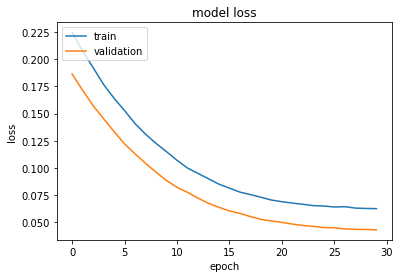

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [101]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate mean absolute error
trainScore1 = math.sqrt(mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE'%(trainScore1))
testScore = math.sqrt(mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))

Train Score: 1.55 MAE
Test Score: 1.50 MAE


In [107]:
print(trainX, testX)

[[[0.52199554]]

 [[0.807704  ]]

 [[0.32444286]]

 [[0.5437603 ]]

 [[0.4853363 ]]

 [[0.12275219]]

 [[0.        ]]

 [[0.1610651 ]]

 [[0.2232933 ]]

 [[0.35125542]]

 [[0.5638685 ]]

 [[1.        ]]

 [[0.32952595]]

 [[0.23689175]]] [[[0.25390434]]

 [[0.19918823]]

 [[0.19918823]]

 [[0.14256096]]

 [[0.3505907 ]]

 [[0.6301079 ]]]


In [98]:
from keras.models import load_model
model = load_model('monthly lstm.h5')


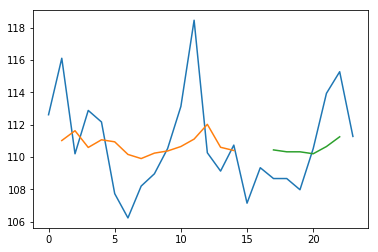

In [102]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [103]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Date","Actual", "Predicted"]

x.add_row([data['Date'].loc[18],data['AQI'].loc[18],testPredict[0]])
x.add_row([data['Date'].loc[19],data['AQI'].loc[19],testPredict[1]])
x.add_row([data['Date'].loc[20],data['AQI'].loc[20],testPredict[2]])
x.add_row([data['Date'].loc[21],data['AQI'].loc[21],testPredict[3]])
x.add_row([data['Date'].loc[22],data['AQI'].loc[22],testPredict[4]])
x.add_row([data['Date'].loc[23],data['AQI'].loc[23],testPredict[5]])

print(x)

+---------------------+--------------------+--------------+
|         Date        |       Actual       |  Predicted   |
+---------------------+--------------------+--------------+
| 2015-07-31 00:00:00 | 108.66666666666666 | [110.439644] |
| 2015-08-31 00:00:00 | 107.97348484848486 | [110.32219]  |
| 2015-09-30 00:00:00 | 110.51999999999998 | [110.32219]  |
| 2015-10-31 00:00:00 | 113.94157088122603 | [110.20158]  |
| 2015-11-30 00:00:00 | 115.28183520599252 | [110.64855]  |
| 2015-12-31 00:00:00 | 111.27491408934704 | [111.25193]  |
+---------------------+--------------------+--------------+
